In [ ]:
# Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
#pip installs
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-bcgkfnfz
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-bcgkfnfz
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263916 sha256=1370f64a5a39486f616a8ef05e0098572806dede43ca93bf0294672bfa00b68b
  Stored in directory: /tmp/pip-ephem-wheel-cache-x9qbcvdo/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2150, done.
remote: Counting objects: 100% (2150/2150), done.
remote: Compressing objects: 100% (477/477), done.
remote: Total 21368 (delta 1668), reused 2058 (delta 1619), pack-reused 19218
Receiving objects: 100% (21368/21368), 21.55 MiB | 18.73 MiB/s, done.
Resolving deltas: 100% (15728/15728), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
#imports

import numpy as np
import pandas as pd
import os
import pycocotools
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
#File Upload Syntax: Col1.1.zip, Col1.1Labels.csv (in content)

In [ ]:
!unzip Col1.1.zip

Archive:  Col1.1.zip
   creating: Col1.1/
  inflating: Col1.1/Col1.1_seg14.png  
   creating: __MACOSX/
   creating: __MACOSX/Col1.1/
  inflating: __MACOSX/Col1.1/._Col1.1_seg14.png  
  inflating: Col1.1/Col1.1_seg2.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg2.png  
  inflating: Col1.1/Col1.1_seg3.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg3.png  
  inflating: Col1.1/Col1.1_seg15.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg15.png  
  inflating: Col1.1/Col1.1_seg17.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg17.png  
  inflating: Col1.1/Col1.1_seg1.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg1.png  
  inflating: Col1.1/Col1.1_seg0.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg0.png  
  inflating: Col1.1/Col1.1_seg16.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg16.png  
  inflating: Col1.1/Col1.1_seg12.png  
  inflating: __MACOSX/Col1.1/._Col1.1_seg12.png  
  inflating: Col1.1/.DS_Store        
  inflating: __MACOSX/Col1.1/._.DS_Store  
  inflating: Col1.1/Col1.1_seg4

In [ ]:
csvnames = ["label","x0","y0","xlen","ylen","filename","ximg","yimg"]
dataset = pd.read_csv("Col1.1Labels.csv", names=csvnames)
filenames = dataset.filename.unique()

print(dataset)

   label   x0  y0  xlen  ylen          filename  ximg  yimg
0   Sign   31   1   131    66   Col1.1_seg0.png   522   131
1   Sign  168   4    86    71   Col1.1_seg0.png   522   131
2   Sign  380   4   117    67   Col1.1_seg0.png   522   131
3   Sign  168  66   121    63   Col1.1_seg0.png   522   131
4   Sign  317  59    88    69   Col1.1_seg0.png   522   131
..   ...  ...  ..   ...   ...               ...   ...   ...
94  Sign  131   4    71    61  Col1.1_seg20.png   522    65
95  Sign  197   3    65    62  Col1.1_seg20.png   522    65
96  Sign  263   0    99    65  Col1.1_seg20.png   522    65
97  Sign  356   0    88    65  Col1.1_seg20.png   522    65
98  Sign  445   0    63    61  Col1.1_seg20.png   522    65

[99 rows x 8 columns]


In [ ]:
class CHCol(object):
  def __init__(self, imgdir, labelset, transforms = None):
    self.transforms = transforms
    self.imgdir = imgdir
    self.imgs = list(sorted(os.listdir(imgdir)))[1:]
    self.labelset = labelset

  def __getitem__(self, idx):
    img_path = os.path.join(self.imgdir, self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    
    filter = self.labelset['filename'] == self.imgs[idx]
    labelsubset = self.labelset[filter]

    xmin = labelsubset.x0.to_numpy()
    ymin = labelsubset.y0.to_numpy()
    xlen = labelsubset.xlen.to_numpy()
    ylen = labelsubset.ylen.to_numpy()

    xmax = xmin + xlen
    ymax = ymin + ylen
    num_signs = len(labelsubset)

    boxes = np.stack((xmin,ymin,xmax,ymax), axis=1)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    area = torch.as_tensor(xlen * ylen, dtype=torch.float32)

    labels = torch.ones(num_signs, dtype=torch.int64)
    image_id = torch.tensor([idx])
    iscrowd = torch.zeros(num_signs, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["iscrowd"] = iscrowd
    target["area"] = area
    
    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

ModuleNotFoundError: ignored

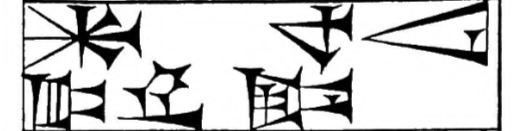

In [ ]:
data = CHCol(imgdir="/content/Col1.1", labelset=dataset, transforms=get_transform(train=True))
data_test = CHCol(imgdir="/content/Col1.1", labelset=dataset, transforms=get_transform(train=False))

sampleimg = data.__getitem__(0)

Image.fromarray(sampleimg[0].mul(255).permute(1, 2, 0).byte().numpy())


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

torch.manual_seed(1)
indices = torch.randperm(len(data)).tolist()
data = torch.utils.data.Subset(data, indices[:-5])
data_test = torch.utils.data.Subset(data_test, indices[-5:])

data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=2, 
                                          shuffle=True, 
                                          num_workers=4, 
                                          collate_fn= utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(data, 
                                               batch_size=2, 
                                               shuffle=True, 
                                               num_workers=4, 
                                               collate_fn= utils.collate_fn)

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

NameError: ignored

In [ ]:
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [0/8]  eta: 0:00:06  lr: 0.000719  loss: 0.9964 (0.9964)  loss_classifier: 0.4813 (0.4813)  loss_box_reg: 0.4345 (0.4345)  loss_objectness: 0.0694 (0.0694)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 0.7799  data: 0.1869  max mem: 791
Epoch: [0]  [7/8]  eta: 0:00:00  lr: 0.005000  loss: 1.1392 (1.1861)  loss_classifier: 0.4129 (0.4136)  loss_box_reg: 0.6740 (0.6950)  loss_objectness: 0.0473 (0.0647)  loss_rpn_box_reg: 0.0111 (0.0128)  time: 0.2904  data: 0.0280  max mem: 1619
Epoch: [0] Total time: 0:00:02 (0.3012 s / it)
creating index...
index created!
Test:  [0/8]  eta: 0:00:02  model_time: 0.0863 (0.0863)  evaluator_time: 0.0085 (0.0085)  time: 0.2785  data: 0.1823  max mem: 1619
Test:  [7/8]  eta: 0:00:00  model_time: 0.0788 (0.0906)  evaluator_time: 0.0111 (0.0128)  time: 0.1316  data: 0.0275  max mem: 1619
Test: Total time: 0:00:01 (0.1438 s / it)
Averaged stats: model_time: 0.0788 (0.0906)  evaluator_time: 0.0111 (0.0128)
Accumulating evaluation results...
DONE (t=0.0

In [ ]:
# pick one image from the test set
img, _ = data_test[-1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[436.9572,   3.1171, 500.7041,  60.4730],
          [ 43.2134,   1.4941, 184.8021,  57.8108],
          [217.8817,   2.0852, 369.9814,  60.3608],
          [336.6215,   3.2738, 435.6959,  57.3512],
          [135.5644,   0.9942, 211.7732,  59.6169],
          [382.8001,   1.8433, 431.6110,  59.8003],
          [362.6098,   2.8161, 492.6480,  60.8958],
          [339.0668,   1.3895, 386.5166,  56.8225],
          [219.7971,   3.9362, 270.6779,  60.1824],
          [255.4613,   2.5376, 319.2831,  61.0000],
          [299.9746,   2.5219, 402.0549,  58.2693],
          [ 74.1892,   0.8009, 144.2374,  58.0171],
          [272.5573,   3.5856, 346.2239,  58.1107],
          [123.0123,   0.0000, 177.4167,  60.5926]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9792, 0.9758, 0.9743, 0.9555, 0.8631, 0.7128, 0.6918, 0.5965, 0.4898,
          0.4652, 0.3121, 0.3066, 0.1857, 0.0872], device='cuda:0')}]

In [ ]:
len(data_test)

5

In [ ]:
from PIL import ImageDraw

def boxsample(n, source, thr = 0.95):
  # pick one image from the test set
  img, _ = source[n]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)

  for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                      decimals= 4)
    if score > thr:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0], boxes[1]), text = str(score), fill=(0,150,0,255))
    #  else:
    #     draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
    #     outline ="blue", width =3)
    #     draw.text((boxes[0], boxes[1]), text = str(score))

  return image

In [ ]:
prediction[0]

{'boxes': tensor([[436.9572,   3.1171, 500.7041,  60.4730],
         [ 43.2134,   1.4941, 184.8021,  57.8108],
         [217.8817,   2.0852, 369.9814,  60.3608],
         [336.6215,   3.2738, 435.6959,  57.3512],
         [135.5644,   0.9942, 211.7732,  59.6169],
         [382.8001,   1.8433, 431.6110,  59.8003],
         [362.6098,   2.8161, 492.6480,  60.8958],
         [339.0668,   1.3895, 386.5166,  56.8225],
         [219.7971,   3.9362, 270.6779,  60.1824],
         [255.4613,   2.5376, 319.2831,  61.0000],
         [299.9746,   2.5219, 402.0549,  58.2693],
         [ 74.1892,   0.8009, 144.2374,  58.0171],
         [272.5573,   3.5856, 346.2239,  58.1107],
         [123.0123,   0.0000, 177.4167,  60.5926]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9792, 0.9758, 0.9743, 0.9555, 0.8631, 0.7128, 0.6918, 0.5965, 0.4898,
         0.4652, 0.3121, 0.3066, 0.1857, 0.0872], device='cuda:0')}

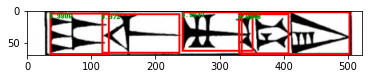

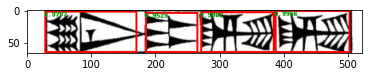

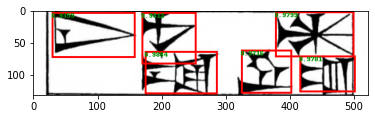

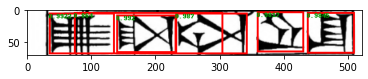

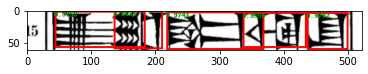

In [ ]:
for n in range(len(data_test)):
  plt.imshow(boxsample(n, data_test, thr=0.8))
  plt.show()

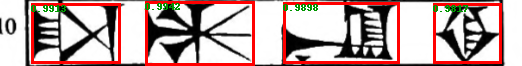

In [ ]:
boxsample(1, data)
